In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных

В качестве данных возьмём ежедневную информацию о курсе Центробанка швейцарского франка к рублю за последний год

In [2]:
%%capture
!wget https://www.dropbox.com/scl/fi/arzso038p5612jcd8avay/rc-f01-12-2022-t01-12-2023.csv

In [3]:
data = pd.read_csv("RC_F01_12_2022_T01_12_2023.csv", delimiter = ";")

In [4]:
data

,nominal,data,curs,cdx
0,1,01.12.2023,"101,248",Швейцарский франк
1,1,30.11.2023,"101,3849",Швейцарский франк
2,1,29.11.2023,"100,6934",Швейцарский франк
3,1,28.11.2023,"100,629",Швейцарский франк
4,1,25.11.2023,"100,4335",Швейцарский франк
...,...,...,...,...
244,1,07.12.2022,"66,6705",Швейцарский франк
245,1,06.12.2022,"66,5506",Швейцарский франк
246,1,03.12.2022,"66,0482",Швейцарский франк
247,1,02.12.2022,"64,7753",Швейцарский франк


In [5]:
data = data.drop(columns = ['nominal', 'cdx'])

In [6]:
data.head(7)

,data,curs
0,01.12.2023,"101,248"
1,30.11.2023,"101,3849"
2,29.11.2023,"100,6934"
3,28.11.2023,"100,629"
4,25.11.2023,"100,4335"
5,24.11.2023,"99,8081"
6,23.11.2023,"99,6888"


In [7]:
data.curs = data.curs.apply(lambda x: x.replace(',', '.'))

In [8]:
data.curs = data.curs.astype(float)

In [9]:
data.head(7)

,data,curs
0,01.12.2023,101.2480
1,30.11.2023,101.3849
2,29.11.2023,100.6934
3,28.11.2023,100.6290
4,25.11.2023,100.4335
5,24.11.2023,99.8081
6,23.11.2023,99.6888


In [10]:
data = data.rename(columns = {'data': 'date', 'curs': 'rate'})

In [11]:
data.date = pd.to_datetime(data.date, format = '%d.%m.%Y')

In [12]:
data.head(7)

,date,rate
0,2023-12-01,101.2480
1,2023-11-30,101.3849
2,2023-11-29,100.6934
3,2023-11-28,100.6290
4,2023-11-25,100.4335
5,2023-11-24,99.8081
6,2023-11-23,99.6888


In [13]:
data = data.sort_values(by = 'date', ignore_index = True)

In [14]:
data

,date,rate
0,2022-12-01,64.0441
1,2022-12-02,64.7753
2,2022-12-03,66.0482
3,2022-12-06,66.5506
4,2022-12-07,66.6705
...,...,...
244,2023-11-25,100.4335
245,2023-11-28,100.6290
246,2023-11-29,100.6934
247,2023-11-30,101.3849


# Реализация индикатора

Для данной работы был выбран индикатор Схождение/расхождение скользящих средних или MACD.

Начнём с того, что вычислим необходимые для построения данного индикатора скользящие средние:
1. С периодом 12 дней
2. С периодом 26 дней

In [15]:
def ema(n, rates):
    weight = 2 / (n + 1)
    ema = rates.copy()
    for i in range(1, rates.shape[0]):
        ema[i] = ema[i] * weight + ema[i - 1] * (1 - weight)
    return ema

In [16]:
ema_12 = ema(12, data.rate)

In [17]:
ema_26 = ema(26, data.rate)

In [18]:
ema_12

0       64.044100
1       64.156592
2       64.447609
3       64.771146
4       65.063354
          ...    
244    100.384487
245    100.422105
246    100.463842
247    100.605544
248    100.704383
Name: rate, Length: 249, dtype: float64

In [19]:
ema_26

0       64.044100
1       64.098263
2       64.242703
3       64.413658
4       64.580832
          ...    
244    102.090444
245    101.982188
246    101.886723
247    101.849551
248    101.804991
Name: rate, Length: 249, dtype: float64

Визуализируем полученные промежуточные результаты:

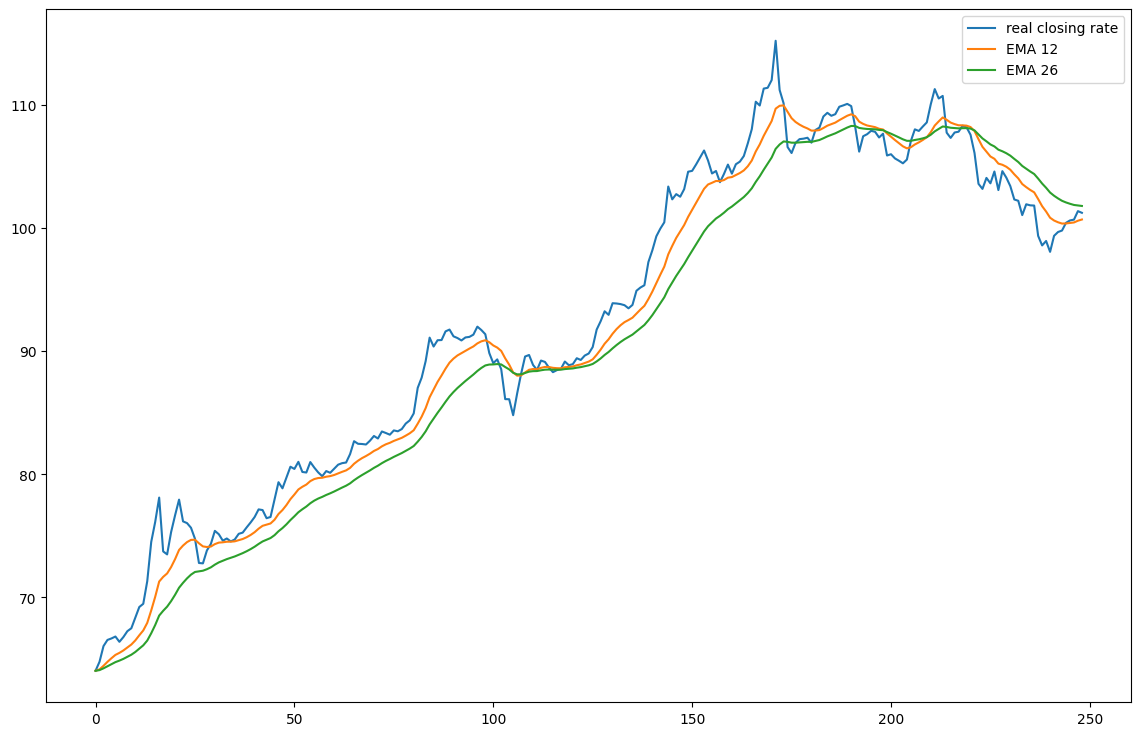

In [20]:
plt.figure(figsize = (14, 9))

plt.plot(data.index, data.rate,
         label='real closing rate')
plt.plot(data.index, ema_12,
         label='EMA 12')
plt.plot(data.index, ema_26,
         label='EMA 26')
plt.legend();

Теперь построим уже линии, собственно, индикатора:
1. MACD = EMA 12 - EMA 26
2. Signal = EMA 9 (MACD)

In [21]:
macd = ema_12 - ema_26
signal = ema(9, macd)

Визуализируем наш индикатор и данные

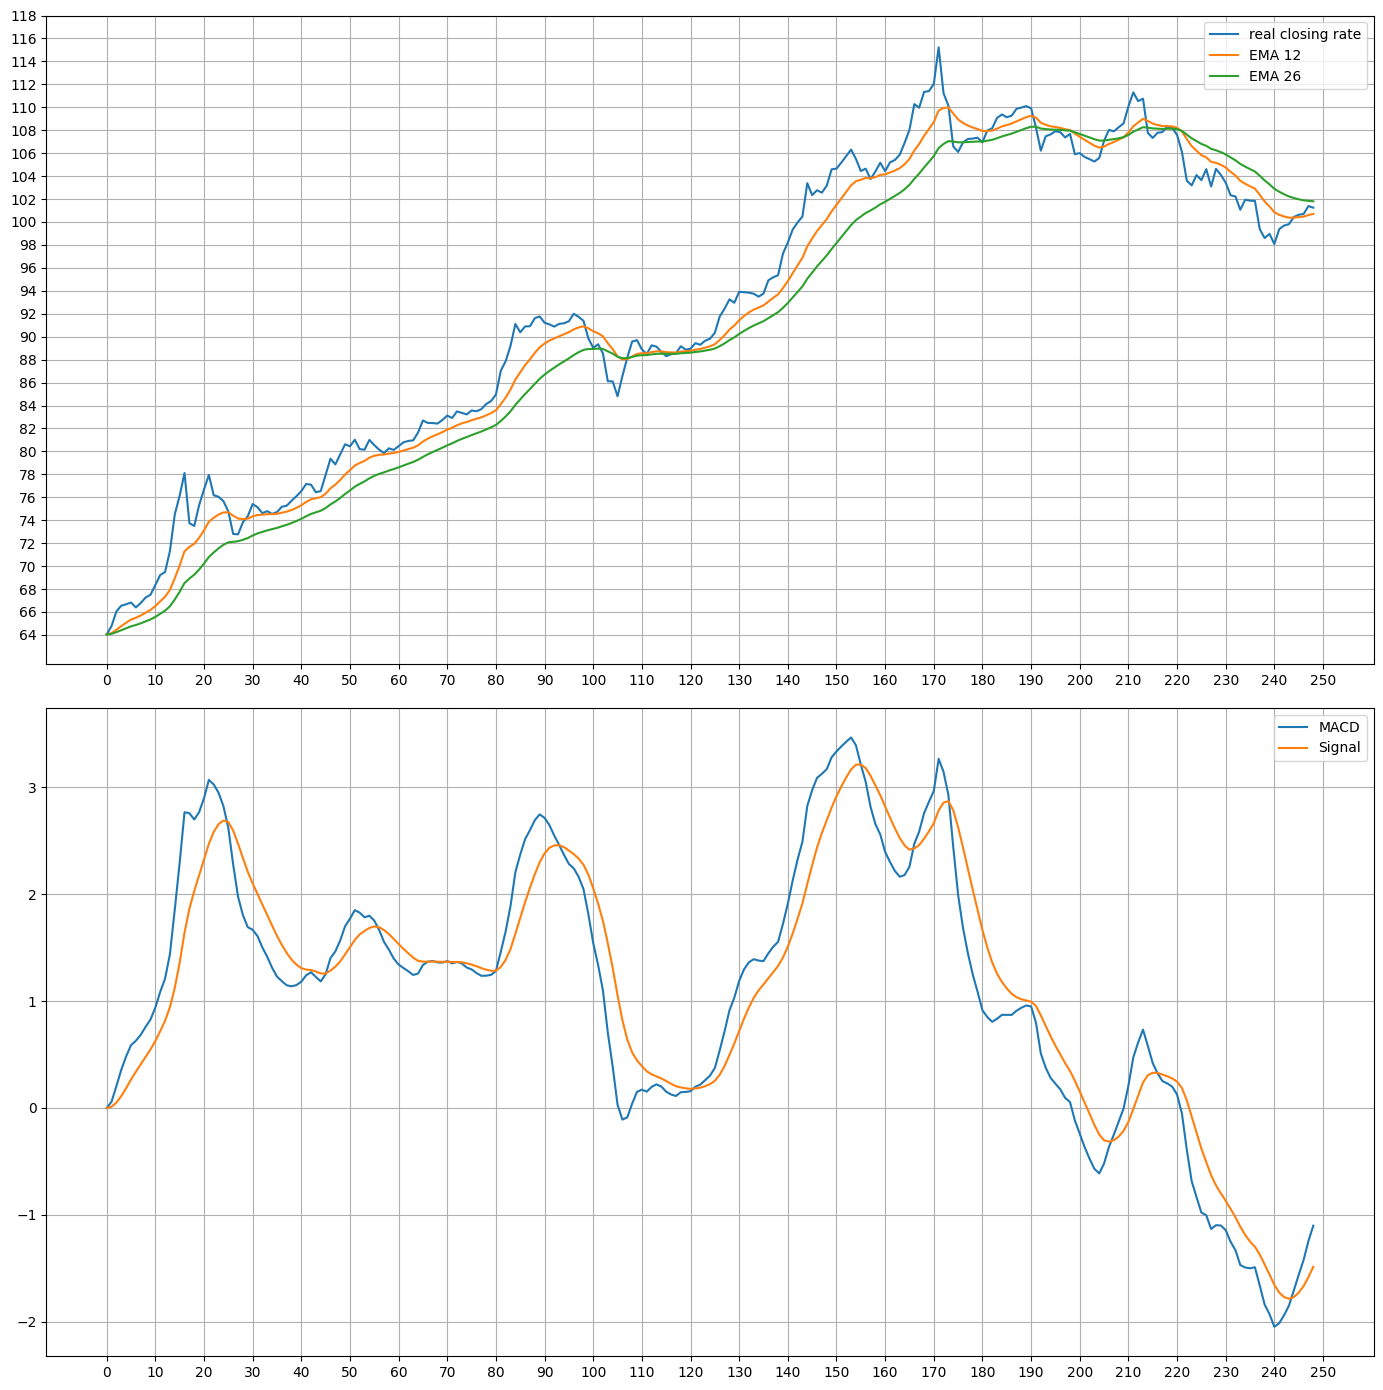

In [48]:
fig, axs = plt.subplots(nrows = 2 , ncols = 1, figsize = (14, 14))
fig.tight_layout()

axs[0].plot(data.index, data.rate, label='real closing rate')
axs[0].plot(data.index, ema_12, label='EMA 12')
axs[0].plot(data.index, ema_26, label='EMA 26')
axs[0].legend();
axs[0].set_xticks(np.linspace(0, 250, 26))
axs[0].set_yticks(np.linspace(64, 118, 28))
axs[0].grid(visible = True, which='both')

axs[1].plot(data.index, macd, label='MACD')
axs[1].plot(data.index, signal, label='Signal')
axs[1].set_xticks(np.linspace(0, 250, 26))
axs[1].set_yticks(np.linspace(-2, 3, 6))
axs[1].grid()
axs[1].legend();

Соберём прописанный выше код в класс MACD и напишем метод рекомендации

In [49]:
class MACD():
    
    def __init__(self, rates):
        self.rates = rates
    
    def construct(self):
        self.macd = ema(12, self.rates) - ema(26, self.rates)
        self.signal = ema(9, self.macd)
    
    def suggest(self):
        if self.macd.iat[-1] > self.signal.iat[-1]:
            return "buy"
        elif self.macd.iat[-1] < self.signal.iat[-1]:
            return "sell"
        elif self.macd.iat[-1] == self.signal.iat[-1]:
            if self.macd.iat[-2] > self.signal.iat[-2]:
                return "sell"
            elif self.macd.iat[-2] < self.signal.iat[-2]:
                return "buy"
        else:
            return "not sure"

In [50]:
md = MACD(data.rate)

In [51]:
md.construct()

In [52]:
md.suggest()

'buy'

Чтобы получить совет на момент желаемой даты, необходимо при создании объекта данного класса передать массив с данными за другой временной период. Совет выдаётся для последнего дня переданного периода